In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import seaborn as sns

### To Do
- Write merged df with patient cohort to .json file
- get histogram done correctly: 
  - build out UPDRS delta col (?) :: change in UPDRS score for a given patient (PATNO) over some period (last being min(date)-max(date))

In [6]:
# Helper functions
def process_errors(frame, start, end) -> list:
    count = 0
    error_indices = []
    for index, row in frame.iterrows():
        checkSum = row.iloc[start:end].sum()
        givenTot = row.iloc[end]

        if checkSum != givenTot:
            print(f"Row {index} check failed: sum {checkSum} does not equal {givenTot}")
            error_indices.append(index)
            count += 1

    error_rows = frame.loc[error_indices]
    if count > 0:
        print("SOME ROWS PRODUCED SUM MIS-MATCH")

    return error_rows

In [7]:
UPDRS3 = "data/MDS-UPDRS_Part_III_10Jun2024.csv"
patient_status = "data/Participant_Status_03Jun2024.csv"

df3 = pd.read_csv(UPDRS3)
df_pat_stat = pd.read_csv(patient_status) #patient status data
df3 = df3.dropna(subset=['NP3TOT']).reset_index()
df3_test = df3.drop(df3.iloc[:, 6:24], axis = 1) # Unnecessary, already removing columns below, so only used for checking error sums
df3['INFODT'] = pd.to_datetime(df3['INFODT'], format="%m/%Y")
stat_keys = list(df_pat_stat['COHORT_DEFINITION'].unique()) #for cohort enum definitions

error_rows = process_errors(df3_test, 6,-6)
if len(error_rows) > 0:
        df3.drop(error_rows, inplace=True, axis=0)

In [61]:
df3['year'] = pd.DatetimeIndex(df3['INFODT']).year
df3['month'] = pd.DatetimeIndex(df3['INFODT']).month

In [62]:
desired_cols_df3 = {'NP3TOT', 'PATNO', 'EVENT_ID', 'ORIG_ENTRY', 'LAST_UPDATE', 'INFODT', 'year', 'month'}
desired_cols_df_pat = {'PATNO', 'COHORT', 'ENROLL_STATUS', 'ENROLL_AGE'}
dropped_cols_df3 = set(df3.columns) - desired_cols_df3
dropped_cols_df_pat = set(df_pat_stat.columns) - desired_cols_df_pat

df3_filtered = df3.drop(columns=dropped_cols_df3)
df_pat_filtered = df_pat_stat.drop(columns=dropped_cols_df_pat)
#merge the two on PATNO
df3_full_filtered = pd.merge(df3_filtered, df_pat_filtered, on="PATNO")
#drop non-enrolled patients
df3_full_filtered = df3_full_filtered[df3_full_filtered['ENROLL_STATUS'] == 'Enrolled']
#check that all PATNO internal entries are monotonic increasing
full_sorted = df3_full_filtered.sort_values(['PATNO', 'year'])

#### Cleaned UPDRS-3 dataset json file, will be used once format confirmed

In [63]:
## Test import of clean UPDRS json file
#test = pd.read_json('data/UPD3_clean.json')
#test['INFODT'] = pd.to_datetime(test['INFODT'], unit='ms')
#test.head(15)

In [64]:
full_sorted.head()

,PATNO,EVENT_ID,INFODT,NP3TOT,ORIG_ENTRY,LAST_UPDATE,year,month,COHORT,ENROLL_STATUS,ENROLL_AGE
0,3000,BL,2011-02-01,4.0,02/2011,2020-06-25 16:02:19.0,2011,2,2,Enrolled,69.1
1,3000,V04,2012-03-01,1.0,03/2012,2020-06-25 16:02:22.0,2012,3,2,Enrolled,69.1
2,3000,V06,2013-02-01,4.0,02/2013,2020-06-25 16:02:22.0,2013,2,2,Enrolled,69.1
3,3000,V08,2014-03-01,2.0,05/2014,2020-06-25 16:02:22.0,2014,3,2,Enrolled,69.1
4,3000,V10,2015-03-01,19.0,03/2015,2020-06-25 16:02:23.0,2015,3,2,Enrolled,69.1


#### GOALS
- CODES: 1 - PD, 2 - Healthy Control, 3 - SWEED (?), 4 - Prodromal (?)
- check that small values aren't rounded to o (or divide by year not day)

#### Fix


- re-work data & histograms accounting for on/off med states, check vs initial distribution (mean 0 and negative bias effect)

- examine individual patient stats in more detail w.r.t to initial distribution, e.x. large negative value subjects 
  - find some way to get fine-grained data on subjects, preferably an interactive visual

- run (delta score) / (delta t) histogram on UPDRS 3 sub scores and plot grouped in panel for visual check (checking for high relative variation and skewed means amoung the summation)

- use plotly when possible, like a grown up 


#### Other Ideas: 
- Group by starting date + cohort(dyagnosis) and map out the evolution of scores from min start dates (should see higher Rate of change/aggregate scores for PD patients) :: (response) Most information found in this graph will be shown more clearly in the histograms, since the mean of the dist will be the rate of change of the plot lines in the graph (1st derivative)

In [51]:
group = full_sorted.groupby('PATNO')
full_sorted['delta_NP3TOT'] = group['NP3TOT'].diff()
full_sorted['delta_days'] = group['INFODT'].diff().dt.days / 365
full_sorted['delta_norm'] = full_sorted['delta_NP3TOT'] / full_sorted['delta_days']
full_sorted.replace([np.inf, -np.inf], np.nan, inplace=True)
full_sorted.dropna(inplace=True)

full_sorted.head(15)

,PATNO,EVENT_ID,INFODT,NP3TOT,ORIG_ENTRY,LAST_UPDATE,year,month,COHORT,ENROLL_STATUS,ENROLL_AGE,delta_NP3TOT,delta_days,delta_norm
3,3000,V08,2014-03-01,2.0,05/2014,2020-06-25 16:02:22.0,2014,3,2,Enrolled,69.1,-2.0,1.076712,-1.857506
4,3000,V10,2015-03-01,19.0,03/2015,2020-06-25 16:02:23.0,2015,3,2,Enrolled,69.1,17.0,1.000000,17.000000
5,3000,V12,2016-04-01,3.0,04/2016,2020-06-25 16:02:23.0,2016,4,2,Enrolled,69.1,-16.0,1.087671,-14.710327
6,3000,V14,2018-02-01,10.0,02/2018,2020-06-25 16:02:24.0,2018,2,2,Enrolled,69.1,7.0,1.838356,3.807750
7,3000,V15,2019-03-01,5.0,04/2019,2020-06-25 16:02:24.0,2019,3,2,Enrolled,69.1,-5.0,1.076712,-4.643766
8,3000,V17,2021-05-01,3.0,06/2021,2021-06-01 00:00:00.0,2021,5,2,Enrolled,69.1,-2.0,2.169863,-0.921717
12,3001,V02,2011-08-01,23.0,08/2011,2020-06-25 16:04:33.0,2011,8,1,Enrolled,65.1,5.0,0.252055,19.836957
13,3001,V03,2011-11-01,19.0,12/2011,2020-06-25 16:04:33.0,2011,11,1,Enrolled,65.1,-4.0,0.252055,-15.869565
14,3001,V04,2012-03-01,20.0,04/2012,2020-06-25 16:04:33.0,2012,3,1,Enrolled,65.1,1.0,0.331507,3.016529
15,3001,V05,2012-09-01,29.0,09/2012,2023-01-05 00:00:00.0,2012,9,1,Enrolled,65.1,9.0,0.504110,17.853261


In [52]:
full_sorted['delta_norm'].max()
full_sorted['delta_norm'].min()

-243.33333333333334

### Distributions

In [53]:
healthy_control_ss = full_sorted[full_sorted['COHORT'] == 2]['PATNO'].unique().size
PD_ss = full_sorted[full_sorted['COHORT'] == 1]['PATNO'].unique().size

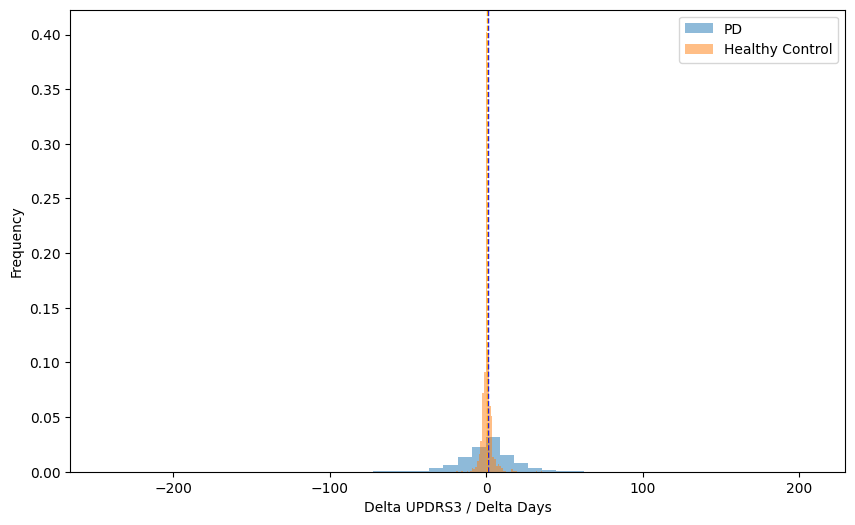

In [60]:
PD_cohort = full_sorted[full_sorted['COHORT']==1]['delta_norm'] #PD
healthy_control_cohort = full_sorted[full_sorted['COHORT']==2]['delta_norm'] #Control 

plt.figure(figsize=(10,6))
plt.hist(PD_cohort, alpha=0.5,bins=50, density=True, label='PD')
plt.hist(healthy_control_cohort,  bins=50, alpha=0.5, density=True, label='Healthy Control')
#plt.xlim((0,0.05))

plt.axvline(PD_cohort.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(healthy_control_cohort.mean(), color='orange', linestyle='dashed', linewidth=1)

plt.xlabel('Delta UPDRS3 / Delta Days')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

In [220]:
PD_cohort

10      -0.214286
11       0.000000
12       0.054348
13      -0.043478
14       0.008264
           ...   
22318   -0.019737
22329   -0.010929
22340   -0.019737
22359   -0.131148
22383   -0.048780
Name: delta_norm, Length: 7045, dtype: float64

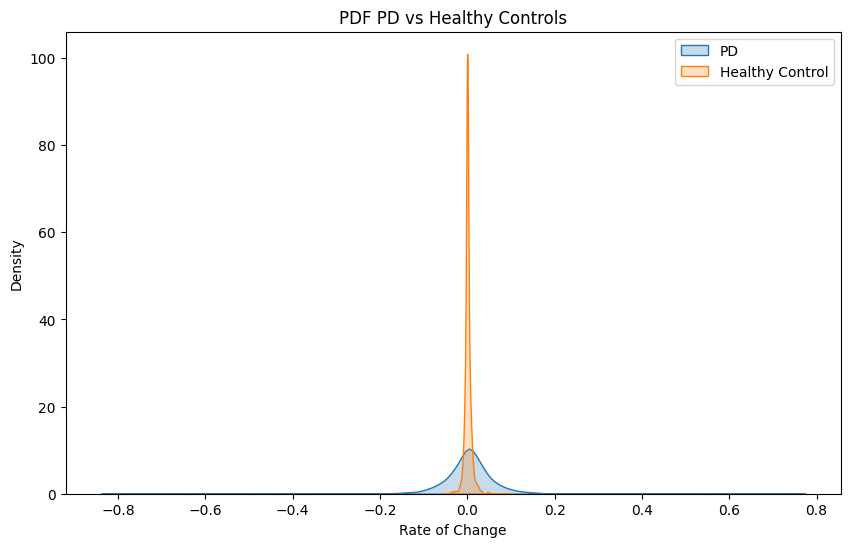

In [219]:
plt.figure(figsize=(10, 6))
sns.kdeplot(PD_cohort, fill=True, label='PD')
sns.kdeplot(healthy_control_cohort, fill=True, label='Healthy Control')

plt.xlabel('Delta UPDRS3 / Delta Days')
plt.ylabel('Density')
plt.title('PDF PD vs Healthy Controls')
plt.legend(loc='upper right')

# Show plot
plt.show()